In [1]:
#V10
#make prom 2d faster
#Delete samplers as soon as they are done.
#i.e. calculate the solution as and error type as soon as we're done and delete.

#get aps erros into one notebook (X)
#push to git.

#run a sample of one frame and push, then run over large number of frames. 

### Imports modules and vector fields

In [2]:
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
#Makes plotting compatible with the Jupyter-notebook dark theme 'monokai'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
from scipy import interpolate
import PIVutils
import PODutils
import grafteaux as G
import automateG as AG
from scipy.ndimage.measurements import find_objects, label, center_of_mass
import prom2d as PP
import time

G = reload(G)
X, Y, U, V,Swirl, Cond,Prof, SwirlFiltPro, SwirlFiltRet, SwirlFilt = G.init_data()

Umean = Prof['U']

xog = X[0,:]
yog = Y[:,0]

del_x = (xog[0]-xog[1])
ar_th  = del_x*del_x*np.pi*25


current path : c:\program files\python37\python.exe
['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']


C:\Users\Kommalapati sahil\AppData\Roaming\Python\Python37\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


0.2439601862683396


### Evaluate the T2 field of the entire frame(s) and find the containing blob radius and prominences


In [4]:
umean2  = np.array([Umean[:,0] for i in range(U.shape[1])]).T

In [5]:
#u2d = np.nanmean(U, axis = 2) #local - pixel mean velocity

centers = {}
proms = {}
areas = {}

t2s = {} #contains the T2 field at that the frame

#evaluating from frame1 to frame2.
frame1, frame2  = 0, 1

for frame in range(frame1, frame2):
    s1 = time.time()

    t2f = G.T2_big_mat(X, Y, U[:,:,frame]-umean2, V[:,:,frame], 2)
    
    #t2f cleaning 
    t21 = t2f.copy()
    t21[t2f<0] = 0 #only prograde 
    t21[t2f<2/np.pi/1.5] = 0 #adding some preliminary threshold 0.66%2/pi
    
    #from every frame collect centers and proms
    
    t2s[frame] = t21
    
    t2_obs= find_objects(label(t21)[0]) #slice objects
    t2_coms_ = center_of_mass(t21, label(t21)[0], [i+1 for i in range(len(t2_obs))]) #center of masses
    t2_coms = np.array(t2_coms_).astype(int)
    print('Beginning..')
    peaks,idmap,promap,parentmap = PP.getProminence(t21,0.01,lats=yog,\
                                                    lons=xog,\
                                                    min_area=ar_th,\
                                                    include_edge=True,\
                                                    verbose = False)
    
    print(f'Frame - {frame} done.' )
    
    cent = []
    prom = []
    aa = []
    for i in peaks.keys():
        
        prom_ = peaks[i]['prominence']
        cc = PP.getind(peaks[i]['center'],xog, yog)
        aa_ = peaks[i]['area']
        cc1 = (cc[1], cc[0])
        
        cent.append(cc1)
        prom.append(prom_)
        aa.append(aa_)
    
    centers[frame] = cent
    proms[frame] = prom
    areas[frame] = aa
    
    s2 = time.time()
    print(f'took {round(s2 - s1,2)} secs.')
    
    #if frame+1 >= fr_th:     break

#we got centers and proms

Beginning..
Frame - 0 done.
took 413.92 secs.


### Functions to get the half prominence regions from the prominence values

In [6]:


def getdims(G):
    '''
    has 1s everywhre
    and 2 at center
    returns ( by-top, by-down, bx-left, bx-right)
    '''
    
    c = np.where(G==2)
    cx, cy  = c[0][0], c[1][0]
    return (cx, len(G)-cx-1, cy, len(G[0])-cy-1)
    
def find_blobs(G, cent, prom, ratio = 0.5, verbose = True):
    '''
    G- the big field
    cent- blob center whose bounds we want
    
    Very naive implementation - can be made significantly faster
    '''
    
    #modify G with prom and ratio
    pr_th = G[cent]-prom*ratio
    G_ = G.copy()
    G_[G<=pr_th] = 0 #only regions with half prom available
    
    G_obs = find_objects(label(G_)[0])
    #print(len(G_obs))
    for i in G_obs:
        #print(i)
        test  = np.zeros(G.shape)
        test[i] = 1
        if test[cent]:
            #this blob contains the cnt
            if verbose:
                plt.figure()
                plt.imshow(test)
                plt.colorbar()
            test[cent] = 2
            dims = getdims(test[i])
            return dims
    return -1

    #indicates that the search was failure 
    #unlikelyy - probably some rounding error somewhere


### Get the extent of the half prominence region from the center

In [7]:
#centers.keys()

In [8]:
##bbdims array - tales centers and proms and 
#gets the half prom (or some custom ratio) blob regions.

#can set verbose in find_blobs = False to not visualize the blobs

bbdims = {}
for i in centers.keys():
    t21 = t2s[i]
        
    #for each frame
    bbcurr = []
    #print('sdfg')
    for cf in range(len(centers[i])):
        bb_ = find_blobs(t21, centers[i][cf], proms[i][cf], ratio = 1, verbose  = False)
        bbcurr.append(bb_)
        #print(bb_)
        #break
    bbdims[i] = bbcurr
    

### Evaluating MCMC on the localized fields

In [9]:
#we have global cents, global blob dims exact, frame 
#mcmc part 

ct = 0
ct_lim = 10

props_dir = {}

mc_soldir = {}
min_soldir = {}

mc_resdir = {}
min_resdir = {}

samp_dir = {}

height_th = [U.shape[0]*0.2, U.shape[0]*0.4]

In [10]:
#newBBdims, newCents
#calculate the min sol and then compare with mc sol.

from scipy import optimize

y = yog.copy()
x = xog.copy()

SR = 5
bounds = [(0.01*2*np.pi*(x[1]-x[0]), None), (x[1]-x[0],np.max(x)),\
          (-1*SR*(x[1]-x[0]),SR*(x[1]-x[0])),(-1*SR*(x[1]-x[0]),SR*(x[1]-x[0])),\
          (-0.15, 0.15)]


Circ = 0.08 #circulation strength
r = 0.03    #radius
xc = 0.02  #center.x 
yc = 0.02   #center.y
Conv = 0 #convective velocity

target = [Circ,r,xc,yc,Conv]

In [11]:
AG = reload(AG)

In [12]:
def calError(props,cen, f, U, V, Cond, k=1.5):
    #return the difference using r
    s, r, x, y, v = props
    yo, xo = cen
    
    dx = 0.010118516377207676
    #print(r)
    x = int(round(x/dx))
    y = int(round(y/dx))
    
    #print(x,y)
    r*= k
    r = int(round(r/dx))
    #print(r)
    
    x+= xo
    y+= yo
    #print(x, y , r)
    if y-r>=0 and y+r < len(U) and x-r>=0 and x+r+1 < len(U[0]):

        U1 = U[y-r:y+r+1, x-r:x+r+1,f]
        V = V[y-r:y+r+1, x-r:x+r+1,f]
        Un = (U1-Umean[y])/Cond['Uinf']
        
        x1, y1  = G.get_xy_rect(Un.shape[0], Un.shape[1])
        #print(x1.shape, Un.shape)
        m_res = PODutils.minfuncVecField10r_rect(props, Un, V, x1, y1)
        return m_res
    else : 
        #print(y-r>=0 , y+r < len(U) , x-r>=0 , x+r+1 < len(U[0]))
        return 0  
    

In [13]:
# m_res = calError(match.x, center, frame, U, V,Cond, k = 1.5 )

In [14]:

ct = 0
ct_lim = 1
bc = 0
f3_count = 0
AG = reload(AG)
for i in centers.keys():
    #for each frame 
    for  j in range(len(centers[i])):
        
        if bbdims[i][j] == -1 : print('bbdims fail.'); continue 
        
        print(f'working on vrtex - {ct}.')
        b1, b2, b3, b4 = bbdims[i][j]
        cy, cx = centers[i][j]
        
        if cy >= height_th[0] and cy <= height_th[1]: 
            
                
            if not (b1+b2+1) %2 : b2 +=1
            if not (b3+b4+1) %2 : b4 +=1

            uu = U[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]
            vv = V[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]
            ss = Swirl[cy-b1:cy+b2+1, cx-b3:cx+b4+1,i]

            uun = (uu-Umean[cy])/Cond['Uinf']

            x1, y1  = G.get_xy_rect(uu.shape[0], uu.shape[1])
            
            samp_test = G.doMCMC_V4(uun, vv, x1, y1)
            
            bbs = bbdims[i][j]
            center = centers[i][j]
            frame = i 
            
            p1 = {}
            p1['bbdims'] = np.array(bbs)
            print(bbs)
            p1['cent'] = center
            p1['frame'] = frame
            props_dir[ct] = p1 
            
            f3 = AG.F3check(samp_test,5000,95)
            
            init = target.copy()

            match = optimize.minimize(PODutils.minfuncVecField10r_rect, x0=init, args=(uun,vv,x1,y1) ,bounds=bounds,\
                             method = 'TNC',options={'maxiter':100000,'disp': True}) #'gtol': 1e-6,

            min_soldir[ct] = match.x
            #m_res = PODutils.minfuncVecField10r_rect(match.x, uun, vv, x1, y1)
            m_res = calError(match.x,center, frame, U, V,Cond, k = 1.5 )
            min_resdir[ct] = m_res
            
            if not f3: 
                #store sampler, mc sol, mc res, min sol, min res
                bc +=1 
                #samp_dir[ct] = samp_test
                mc_soldir[ct] = AG.cornerSol(samp_test, 5000)
                mc_res = calError(mc_soldir[ct], center, frame, U, V,Cond, k = 1.5 )
                #mc_resdir[ct] = PODutils.minfuncVecField10r_rect(mc_soldir[ct], uun, vv, x1, y1)
                mc_resdir[ct] = mc_res
                
                
            else: 
                
                f3_count+=1 
                #do corrections et al. 
                print(f'Corrections on the vortex - {ct}.')
                props = props_dir[ct]
                solZip = AG.DcorrectionV4(Cond, U, V, Umean, props, samp_test)
                if solZip !=  -1:
                    #samp_dir[ct] = solZip[0]
                    props_dir[ct]['bbdims'] = solZip[1]
                    mc_resdir[ct] = solZip[2]
                else: 
                    #samp_dir[ct] = samp_test 
                    mc_resdir[ct] = -1 
            print(f'vortex - {ct} done.')
            del samp_test 
            ct+=1
            #if ct>= ct_lim: break
    #else: continue 
    #break #comes here when break in loop executed
        

working on vrtex - 0.
(3, 5, 8, 7)
Corrections on the vortex - 0.
working on rad: (4, 6, 9, 9)  rth- 16
working on rad: (5, 7, 10, 10)  rth- 16
working on rad: (6, 8, 11, 11)  rth- 16
working on rad: (7, 9, 12, 12)  rth- 16
working on rad: (8, 10, 13, 13)  rth- 16
working on rad: (9, 11, 14, 14)  rth- 16
working on rad: (10, 12, 15, 15)  rth- 16
working on rad: (11, 13, 16, 16)  rth- 16
threshold reached!
vortex - 0 done.
working on vrtex - 1.
(4, 3, 11, 2)
Corrections on the vortex - 1.
working on rad: (5, 5, 12, 4)  rth- 22
working on rad: (6, 6, 13, 5)  rth- 22
working on rad: (7, 7, 14, 6)  rth- 22
working on rad: (8, 8, 15, 7)  rth- 22
working on rad: (9, 9, 16, 8)  rth- 22
working on rad: (10, 10, 17, 9)  rth- 22
working on rad: (11, 11, 18, 10)  rth- 22
working on rad: (12, 12, 19, 11)  rth- 22
out of bounds!
vortex - 1 done.
working on vrtex - 2.
(4, 3, 9, 4)
vortex - 2 done.
working on vrtex - 3.
working on vrtex - 3.
working on vrtex - 3.
working on vrtex - 3.
working on vrte

In [15]:
i

0

In [16]:
len(centers.keys())

1

In [17]:
AG = reload(AG)

In [19]:
lkeys = [i for i in mc_soldir.keys() if mc_resdir[i] != -1]

i1 = lkeys[0]
mc_sols = []
for i1 in lkeys:
    stemp = mc_soldir[i1]
    mc_sols.append(stemp)

In [20]:
props_save = [props_dir[i] for i in lkeys]
#mc_save = np.array([AG.cornerSol(samp_dir[i], 5000) for i in lkeys ])
mn_save = [min_soldir[i] for i in lkeys]

In [21]:
Nsave = np.array([props_save, mc_sols, mn_save])
np.save(f'F{frame1}-{frame2}.npy', Nsave, allow_pickle = True)

### APS-Error Analysis

In [22]:
#1. PDF of PDF of 5 parameters
#2. Box and Wiskers plot comparing Min and MCMC (x)

In [23]:
import sys
sys.path.append('/GITHUB/CoherentStructures')

In [30]:
import BoxPlot 
bplt = reload(BoxPlot)

current path : c:\program files\python37\python.exe
['#refs#', 'AutoCorr', 'Cond', 'Corr', 'CorrT', 'Err', 'PercentMissing', 'Prof', 'Quad', 'Swirl', 'U', 'V', 'W', 'X', 'Y', 'source']
0.2439601862683396


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.16it/s]


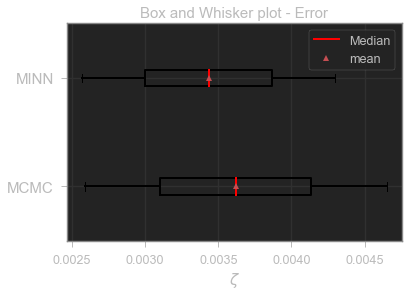

0

In [31]:
F0 = np.load(f'F{frame}-{frame2}.npy', allow_pickle = True)

files = [F0]

BoxPlot.plot_bw(files)

0

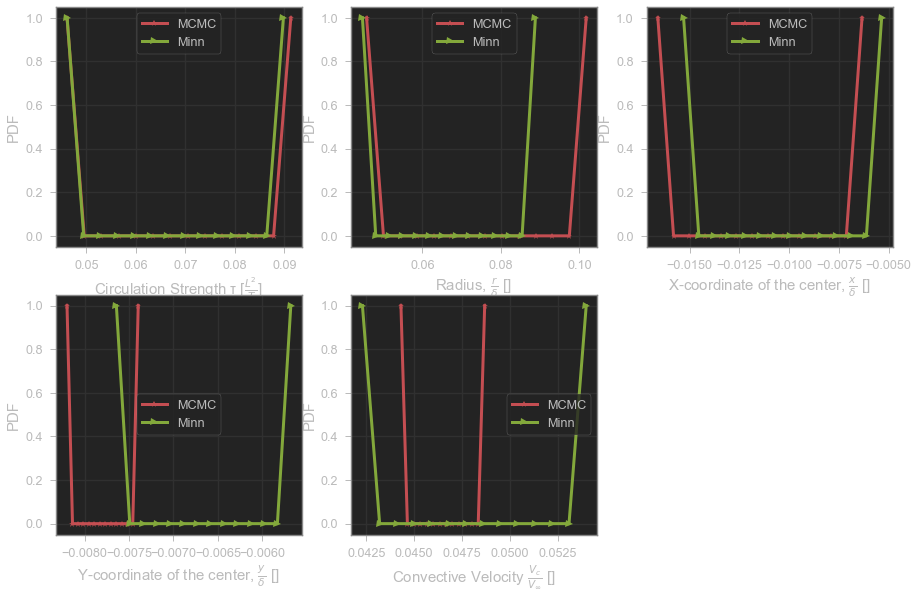

In [32]:
#PDF
MC_sols = []
MC_sols.extend(F0[1])

Mn_sols = []
Mn_sols.extend(F0[2])

bplt.plotBigHist(MC_sols, Mn_sols, bins_ = 14)


### Using data from frame 0 to frame 66

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]


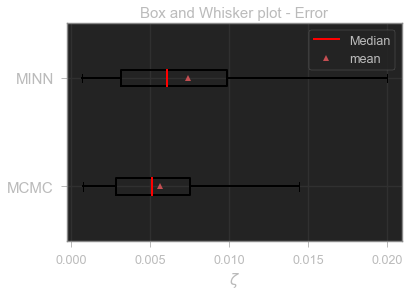

0

In [33]:
F0 = np.load('F00-63.npy', allow_pickle = True)

files = [F0]

BoxPlot.plot_bw(files)

0

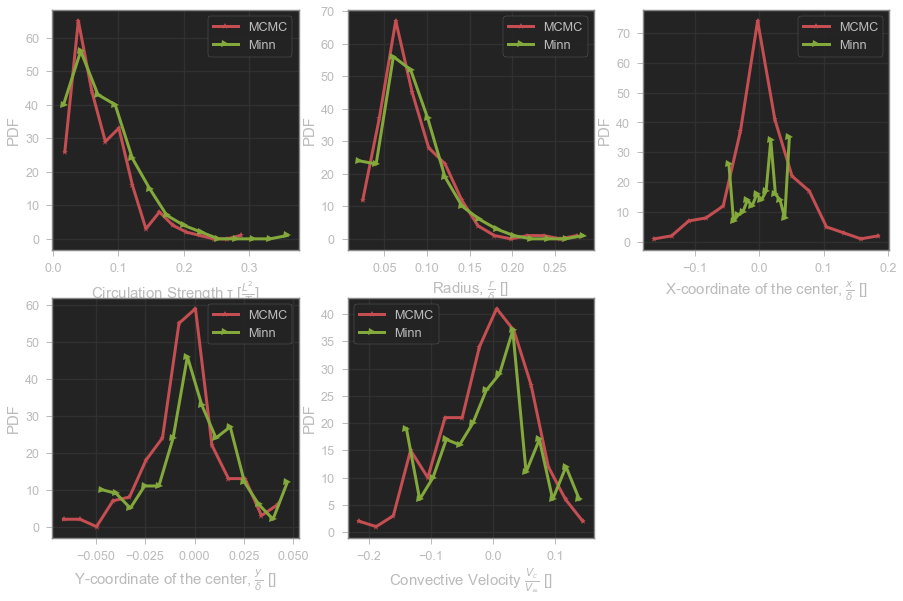

In [34]:
#PDF
MC_sols = []
MC_sols.extend(F0[1])

Mn_sols = []
Mn_sols.extend(F0[2])

bplt.plotBigHist(MC_sols, Mn_sols, bins_ = 14)
